In [1]:
%load_ext autoreload
%autoreload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from scipy import stats
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from MLP.mlp_regression import mlp_regression, model_validation, mlp_prediction, mlp_prediction_error, mlp_train_graph, errorDist, mlp_train_multi_graph, mlp_train_multi_graph_comb, mlp_train_multi_3dgraph_comb
from MLP.utils import combineArray, multiArraySort, data_loader_from_csv, data_loader_pathloss, describeData, data_loader_pathloss_with_freq
from GMM.utils import gp_train_multi_3dgraph, gp_ann_train_multi_3dgraph, gpCompareDiffDim, mergeSet

pd.set_option('display.max_rows', 999)
pd.set_option('precision', 5)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
%autoreload
X_train_m_400, X_val_m_400, y_train_m_400, y_val_m_400, X_train_s_400, X_val_s_400, y_train_s_400, y_val_s_400 = data_loader_from_csv('data/PLdata_nonsan_wt_400.csv', np.log10(400), 'dist' ,2.3, testRatio=0.8)
X_train_m_1399, X_val_m_1399, y_train_m_1399, y_val_m_1399, X_train_s_1399, X_val_s_1399, y_train_s_1399, y_val_s_1399 = data_loader_from_csv('data/PLdata_nonsan_wt_1399.csv', np.log10(1399),'dist', 2.3, testRatio=0.8)
X_train_m_2249, X_val_m_2249, y_train_m_2249, y_val_m_2249, X_train_s_2249, X_val_s_2249, y_train_s_2249, y_val_s_2249 = data_loader_from_csv('data/PLdata_nonsan_wt_2249.csv', np.log10(2249),'dist', 2.3, testRatio=0.8)

X_train_m = combineArray(X_train_m_400, X_train_m_1399, X_train_m_2249)
y_train_m = combineArray(y_train_m_400, y_train_m_1399, y_train_m_2249)
X_val_m = combineArray(X_val_m_400, X_val_m_1399, X_val_m_2249)
y_val_m = combineArray(y_val_m_400, y_val_m_1399, y_val_m_2249)

X_train_s = combineArray(X_train_s_400, X_train_s_1399, X_train_s_2249)
y_train_s = combineArray(y_train_s_400, y_train_s_1399, y_train_s_2249)
X_val_s = combineArray(X_val_s_400, X_val_s_1399, X_val_s_2249)
y_val_s = combineArray(y_val_s_400, y_val_s_1399, y_val_s_2249)

dataX_m = list()
dataY_m = list()
dataX_m.append(X_train_m_400)
dataY_m.append(y_train_m_400)
dataX_m.append(X_train_m_1399)
dataY_m.append(y_train_m_1399)
dataX_m.append(X_train_m_2249)
dataY_m.append(y_train_m_2249)

X_train_m_400

original: 114545
filtered: 13456
Covariance Matrix
           dist      ploss   height
dist    0.37188    5.98064  0.00204
ploss   5.98064  167.97724  0.03692
height  0.00204    0.03692  0.00043
--------------------------------------------------
Preprocessing <data/PLdata_nonsan_wt_400.csv>...Total 13456
- moving type: total: 10458 (training: 2091/validation: 8367)
- stationary type: total: 2998 (training: 599/validation: 2399)
original: 114455
filtered: 13406
Covariance Matrix
           dist      ploss   height
dist    0.36645    6.68311  0.00201
ploss   6.68311  203.15810  0.04374
height  0.00201    0.04374  0.00043
--------------------------------------------------
Preprocessing <data/PLdata_nonsan_wt_1399.csv>...Total 13406
- moving type: total: 10408 (training: 2081/validation: 8327)
- stationary type: total: 2998 (training: 599/validation: 2399)
original: 114341
filtered: 13339
Covariance Matrix
           dist      ploss   height
dist    0.35902    6.51480  0.00197
ploss   6.51

array([[2.04178889, 2.60205999],
       [2.06643634, 2.60205999],
       [2.10081136, 2.60205999],
       ...,
       [3.3615857 , 2.60205999],
       [3.36165588, 2.60205999],
       [3.36166415, 2.60205999]])

In [9]:
X = X_train_m
y = y_train_m

# Instantiate a Gaussian Process model
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
# kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
#    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
gp_ma = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0)
# Fit to data using Maximum Likelihood Estimation of the parameters
gp_ma.fit(X, y)

filename = 'model/gp_nonsan_wt_3d_model.sav'
pickle.dump(gp_ma, open(filename, 'wb'))

<Nonsan - Winter> Gaussian Process (dist<=2300m)


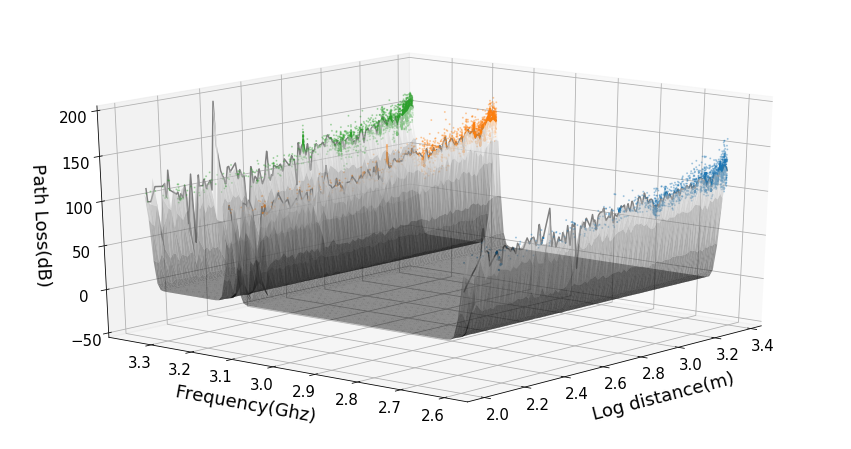

TEST ERROR(dB),RMSE,MAE,MAPE,MSLE,R2
0.4Ghz,7.60942,5.44605,4.83478,0.00469,0.56387
1.399Ghz,8.37151,6.10200,4.94037,0.00583,0.62576
2.249Ghz,8.42965,6.00961,4.68297,0.00482,0.58229
Overall,8.14398,5.85156,4.81969,0.00511,0.72271


In [7]:
%autoreload
model = None
model = pickle.load(open('model/gp_nonsan_wt_3d_model.sav', 'rb'))

print("<Nonsan - Winter> Gaussian Process (dist<=2300m)")
mlp_train_multi_3dgraph_comb(model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'], False, 'gray')

y_pred_400 = model.predict(X_val_m_400)
y_pred_1399 = model.predict(X_val_m_1399)
y_pred_2249 = model.predict(X_val_m_2249)
y_pred = model.predict(X_val_m)
stat = np.array([mlp_prediction_error(model,X_val_m_400, y_val_m_400),mean_absolute_error(y_pred_400, y_val_m_400),mean_absolute_percentage_error(y_pred_400, y_val_m_400),mean_squared_log_error(y_pred_400, y_val_m_400),r2_score(y_pred_400, y_val_m_400),
                 mlp_prediction_error(model,X_val_m_1399, y_val_m_1399),mean_absolute_error(y_pred_1399, y_val_m_1399),mean_absolute_percentage_error(y_pred_1399, y_val_m_1399),mean_squared_log_error(y_pred_1399, y_val_m_1399),r2_score(y_pred_1399, y_val_m_1399),
                 mlp_prediction_error(model,X_val_m_2249, y_val_m_2249),mean_absolute_error(y_pred_2249, y_val_m_2249),mean_absolute_percentage_error(y_pred_2249, y_val_m_2249),mean_squared_log_error(y_pred_2249, y_val_m_2249),r2_score(y_pred_2249, y_val_m_2249),
                 mlp_prediction_error(model,X_val_m, y_val_m), mean_absolute_error(y_pred, y_val_m),mean_absolute_percentage_error(y_pred, y_val_m),mean_squared_log_error(y_pred, y_val_m),r2_score(y_pred, y_val_m)])

(pd.DataFrame(stat.reshape((4,5)),index=pd.Index(['0.4Ghz','1.399Ghz','2.249Ghz', 'Overall']), columns=pd.Index(['RMSE','MAE','MAPE','MSLE','R2'],name='TEST ERROR(dB)')))

<Nonsan - Winter> Gaussian Process STD(standard deviation) Distribution (dist<=2300m)


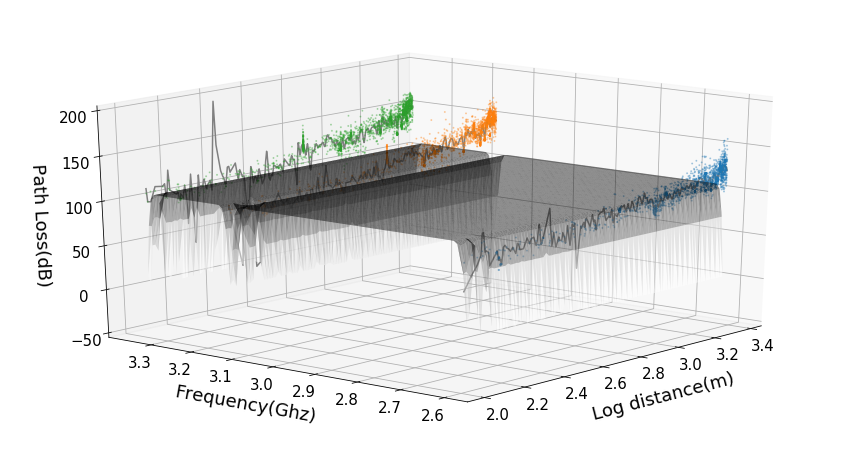

In [10]:
%autoreload
model = None
model = pickle.load(open('model/gp_nonsan_wt_3d_model.sav', 'rb'))

print("<Nonsan - Winter> Gaussian Process STD(standard deviation) Distribution (dist<=2300m)")
mlp_train_multi_3dgraph_comb(model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'], True, 'Greys')

In [3]:
X = X_train_m
y = y_train_m

# Instantiate a Gaussian Process model
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
# kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
#    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))\
        + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel)
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

filename = 'model/gp_RBF_1_nonsan_wt_3d_model.sav'
pickle.dump(gp, open(filename, 'wb'))

<Nonsan - Winter> Gaussian Process (dist<=2300m)


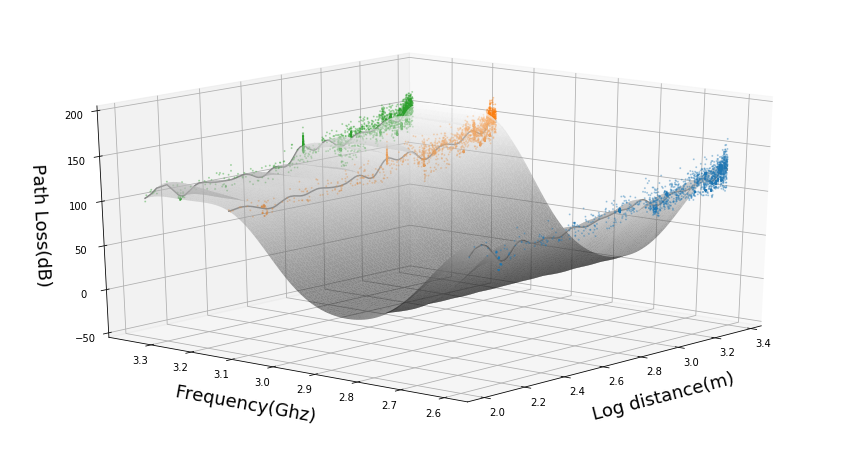

TEST ERROR(dB),RMSE,MAE,MAPE,MSLE,R2
0.4Ghz,7.72819,6.03602,5.26155,0.00443,0.51295
1.399Ghz,8.79461,7.04012,5.29588,0.00439,0.49460
2.249Ghz,7.98966,6.30251,4.72325,0.00359,0.54942
Overall,8.18312,6.45921,5.09463,0.00414,0.68867


In [8]:
%autoreload
model = None
model = pickle.load(open('model/gp_RBF_1_nonsan_wt_3d_model.sav', 'rb'))

print("<Nonsan - Winter> Gaussian Process (dist<=2300m)")
mlp_train_multi_3dgraph_comb(model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'], False, 'gray')

y_pred_400 = model.predict(X_val_m_400)
y_pred_1399 = model.predict(X_val_m_1399)
y_pred_2249 = model.predict(X_val_m_2249)
y_pred = model.predict(X_val_m)
stat = np.array([mlp_prediction_error(model,X_val_m_400, y_val_m_400),mean_absolute_error(y_pred_400, y_val_m_400),mean_absolute_percentage_error(y_pred_400, y_val_m_400),mean_squared_log_error(y_pred_400, y_val_m_400),r2_score(y_pred_400, y_val_m_400),
                 mlp_prediction_error(model,X_val_m_1399, y_val_m_1399),mean_absolute_error(y_pred_1399, y_val_m_1399),mean_absolute_percentage_error(y_pred_1399, y_val_m_1399),mean_squared_log_error(y_pred_1399, y_val_m_1399),r2_score(y_pred_1399, y_val_m_1399),
                 mlp_prediction_error(model,X_val_m_2249, y_val_m_2249),mean_absolute_error(y_pred_2249, y_val_m_2249),mean_absolute_percentage_error(y_pred_2249, y_val_m_2249),mean_squared_log_error(y_pred_2249, y_val_m_2249),r2_score(y_pred_2249, y_val_m_2249),
                 mlp_prediction_error(model,X_val_m, y_val_m), mean_absolute_error(y_pred, y_val_m),mean_absolute_percentage_error(y_pred, y_val_m),mean_squared_log_error(y_pred, y_val_m),r2_score(y_pred, y_val_m)])

(pd.DataFrame(stat.reshape((4,5)),index=pd.Index(['0.4Ghz','1.399Ghz','2.249Ghz', 'Overall']), columns=pd.Index(['RMSE','MAE','MAPE','MSLE','R2'],name='TEST ERROR(dB)')))

<Nonsan - Winter> Gaussian Process STD(standard deviation) Distribution (dist<=2300m)


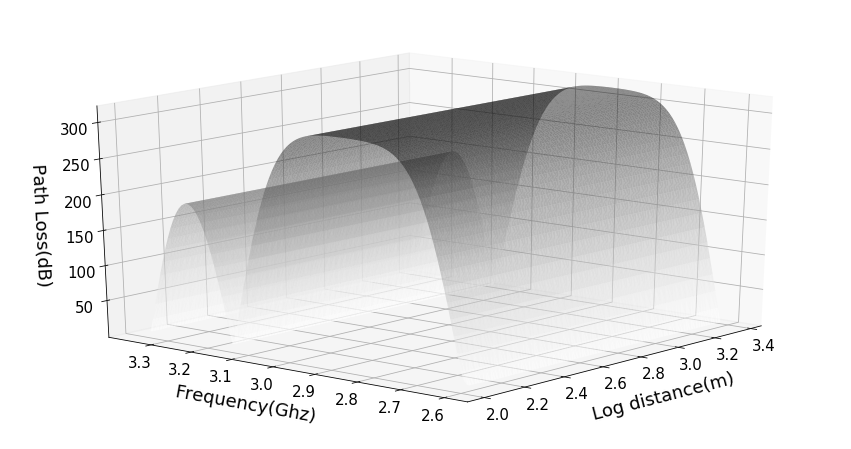

In [13]:
%autoreload
model = None
model = pickle.load(open('model/gp_RBF_1_nonsan_wt_3d_model.sav', 'rb'))

print("<Nonsan - Winter> Gaussian Process STD(standard deviation) Distribution (dist<=2300m)")
mlp_train_multi_3dgraph_comb(model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'], True, 'Greys')

In [4]:
X = X_train_m
y = y_train_m

# Instantiate a Gaussian Process model
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
# kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
#    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
kernel = 1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)\
        + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel)
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

filename = 'model/gp_RQ_nonsan_wt_3d_model.sav'
pickle.dump(gp, open(filename, 'wb'))

<Nonsan - Winter> Gaussian Process (dist<=2300m)


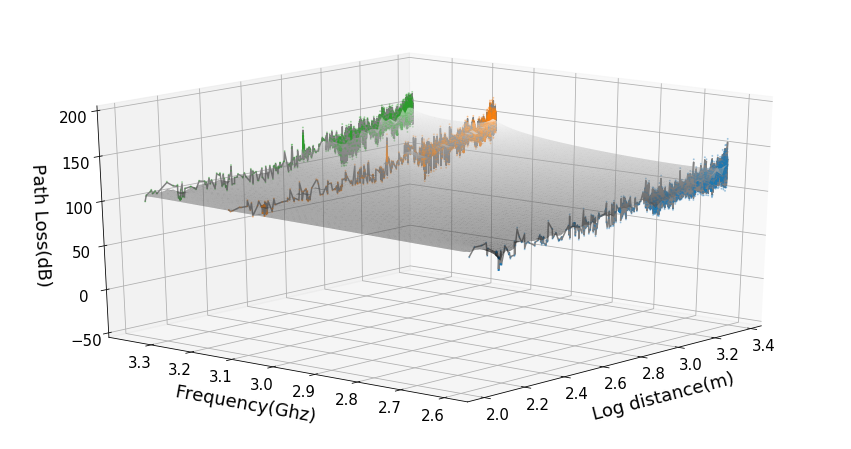

TEST ERROR(dB),RMSE,MAE,MAPE,MSLE,R2
0.4Ghz,7.21652,4.95479,4.31659,0.00381,0.60519
1.399Ghz,7.68153,5.63331,4.26383,0.00336,0.66861
2.249Ghz,7.40086,5.43325,4.07800,0.00306,0.65367
Overall,7.43516,5.33963,4.21993,0.00341,0.76037


In [9]:
%autoreload
model = None
model = pickle.load(open('model/gp_RQ_nonsan_wt_3d_model.sav', 'rb'))

print("<Nonsan - Winter> Gaussian Process (dist<=2300m)")
mlp_train_multi_3dgraph_comb(model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'], False, 'gray')

y_pred_400 = model.predict(X_val_m_400)
y_pred_1399 = model.predict(X_val_m_1399)
y_pred_2249 = model.predict(X_val_m_2249)
y_pred = model.predict(X_val_m)
stat = np.array([mlp_prediction_error(model,X_val_m_400, y_val_m_400),mean_absolute_error(y_pred_400, y_val_m_400),mean_absolute_percentage_error(y_pred_400, y_val_m_400),mean_squared_log_error(y_pred_400, y_val_m_400),r2_score(y_pred_400, y_val_m_400),
                 mlp_prediction_error(model,X_val_m_1399, y_val_m_1399),mean_absolute_error(y_pred_1399, y_val_m_1399),mean_absolute_percentage_error(y_pred_1399, y_val_m_1399),mean_squared_log_error(y_pred_1399, y_val_m_1399),r2_score(y_pred_1399, y_val_m_1399),
                 mlp_prediction_error(model,X_val_m_2249, y_val_m_2249),mean_absolute_error(y_pred_2249, y_val_m_2249),mean_absolute_percentage_error(y_pred_2249, y_val_m_2249),mean_squared_log_error(y_pred_2249, y_val_m_2249),r2_score(y_pred_2249, y_val_m_2249),
                 mlp_prediction_error(model,X_val_m, y_val_m), mean_absolute_error(y_pred, y_val_m),mean_absolute_percentage_error(y_pred, y_val_m),mean_squared_log_error(y_pred, y_val_m),r2_score(y_pred, y_val_m)])

(pd.DataFrame(stat.reshape((4,5)),index=pd.Index(['0.4Ghz','1.399Ghz','2.249Ghz', 'Overall']), columns=pd.Index(['RMSE','MAE','MAPE','MSLE','R2'],name='TEST ERROR(dB)')))

<Nonsan - Winter> Gaussian Process STD(standard deviation) Distribution (dist<=2300m)


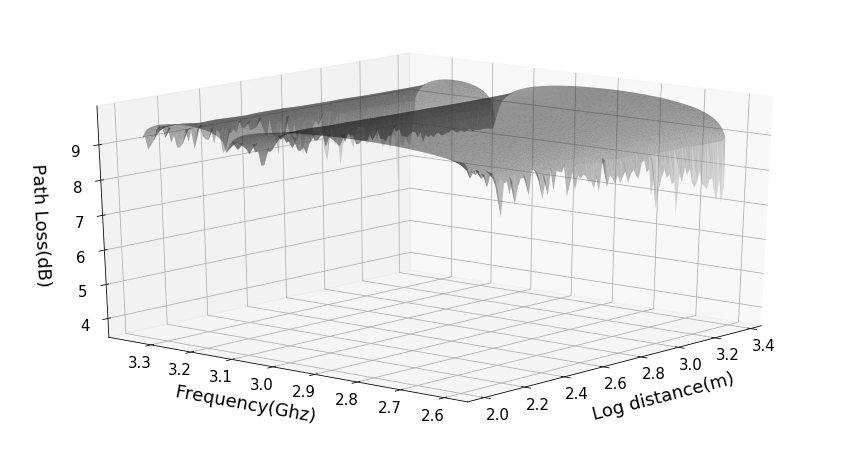

In [14]:
%autoreload
model = None
model = pickle.load(open('model/gp_RQ_nonsan_wt_3d_model.sav', 'rb'))

print("<Nonsan - Winter> Gaussian Process STD(standard deviation) Distribution (dist<=2300m)")
mlp_train_multi_3dgraph_comb(model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'], True, 'Greys')

In [5]:
X = X_train_m
y = y_train_m

# Instantiate a Gaussian Process model
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
# kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
#    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
kernel = 1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0))\
        + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel)
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

filename = 'model/gp_ESS_nonsan_wt_3d_model.sav'
pickle.dump(gp, open(filename, 'wb'))

<Nonsan - Winter> Gaussian Process (dist<=2300m)


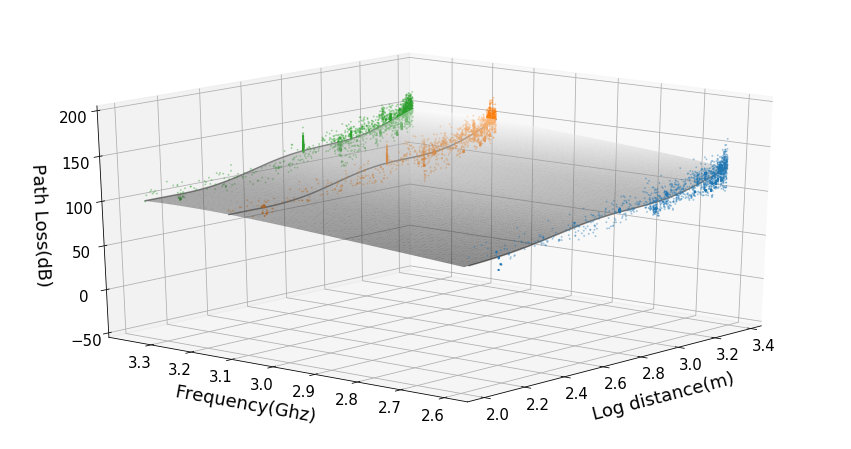

TEST ERROR(dB),RMSE,MAE,MAPE,MSLE,R2
0.4Ghz,8.31237,6.76181,5.89818,0.00518,0.37672
1.399Ghz,9.46936,7.70988,5.81629,0.00516,0.34523
2.249Ghz,8.72330,6.95046,5.22296,0.00434,0.38954
Overall,8.84742,7.14052,5.64713,0.00490,0.61071


In [10]:
%autoreload
model = None
model = pickle.load(open('model/gp_ESS_nonsan_wt_3d_model.sav', 'rb'))

print("<Nonsan - Winter> Gaussian Process (dist<=2300m)")
mlp_train_multi_3dgraph_comb(model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'], False, 'gray')

y_pred_400 = model.predict(X_val_m_400)
y_pred_1399 = model.predict(X_val_m_1399)
y_pred_2249 = model.predict(X_val_m_2249)
y_pred = model.predict(X_val_m)
stat = np.array([mlp_prediction_error(model,X_val_m_400, y_val_m_400),mean_absolute_error(y_pred_400, y_val_m_400),mean_absolute_percentage_error(y_pred_400, y_val_m_400),mean_squared_log_error(y_pred_400, y_val_m_400),r2_score(y_pred_400, y_val_m_400),
                 mlp_prediction_error(model,X_val_m_1399, y_val_m_1399),mean_absolute_error(y_pred_1399, y_val_m_1399),mean_absolute_percentage_error(y_pred_1399, y_val_m_1399),mean_squared_log_error(y_pred_1399, y_val_m_1399),r2_score(y_pred_1399, y_val_m_1399),
                 mlp_prediction_error(model,X_val_m_2249, y_val_m_2249),mean_absolute_error(y_pred_2249, y_val_m_2249),mean_absolute_percentage_error(y_pred_2249, y_val_m_2249),mean_squared_log_error(y_pred_2249, y_val_m_2249),r2_score(y_pred_2249, y_val_m_2249),
                 mlp_prediction_error(model,X_val_m, y_val_m), mean_absolute_error(y_pred, y_val_m),mean_absolute_percentage_error(y_pred, y_val_m),mean_squared_log_error(y_pred, y_val_m),r2_score(y_pred, y_val_m)])

(pd.DataFrame(stat.reshape((4,5)),index=pd.Index(['0.4Ghz','1.399Ghz','2.249Ghz', 'Overall']), columns=pd.Index(['RMSE','MAE','MAPE','MSLE','R2'],name='TEST ERROR(dB)')))

<Nonsan - Winter> Gaussian Process STD(standard deviation) Distribution (dist<=2300m)


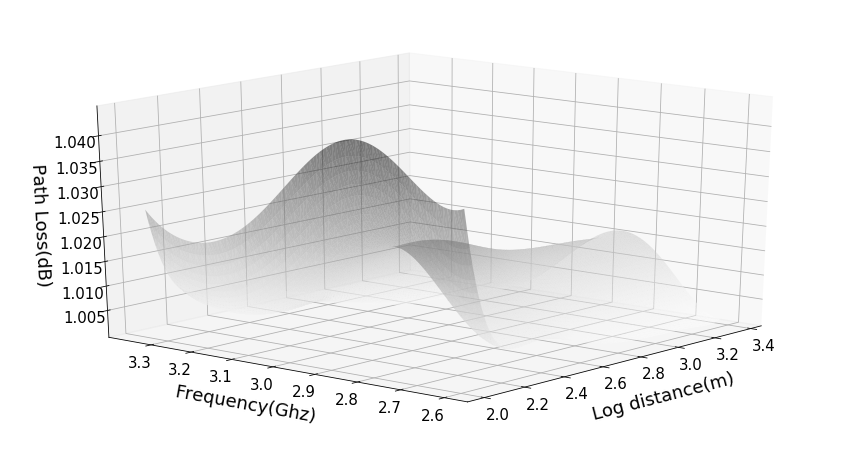

In [15]:
%autoreload
model = None
model = pickle.load(open('model/gp_ESS_nonsan_wt_3d_model.sav', 'rb'))

print("<Nonsan - Winter> Gaussian Process STD(standard deviation) Distribution (dist<=2300m)")
mlp_train_multi_3dgraph_comb(model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'], True, 'Greys')

In [6]:
X = X_train_m
y = y_train_m

# Instantiate a Gaussian Process model
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
# kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
#    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
kernel = ConstantKernel(0.1, (0.01, 10.0)) * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2)\
        + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel)
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

filename = 'model/gp_DP_nonsan_wt_3d_model.sav'
pickle.dump(gp, open(filename, 'wb'))

<Nonsan - Winter> Gaussian Process (dist<=2300m)


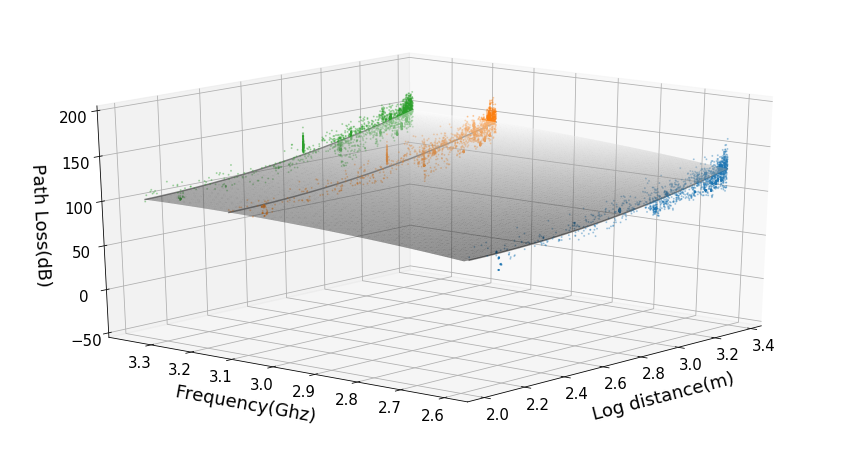

TEST ERROR(dB),RMSE,MAE,MAPE,MSLE,R2
0.4Ghz,8.50289,7.03880,6.12735,0.00549,0.31402
1.399Ghz,9.92980,8.19781,6.20770,0.00571,0.19112
2.249Ghz,9.06127,7.17164,5.39522,0.00471,0.33814
Overall,9.18265,7.46937,5.91155,0.00531,0.56098


In [11]:
%autoreload
model = None
model = pickle.load(open('model/gp_DP_nonsan_wt_3d_model.sav', 'rb'))

print("<Nonsan - Winter> Gaussian Process (dist<=2300m)")
mlp_train_multi_3dgraph_comb(model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'], False, 'gray')

y_pred_400 = model.predict(X_val_m_400)
y_pred_1399 = model.predict(X_val_m_1399)
y_pred_2249 = model.predict(X_val_m_2249)
y_pred = model.predict(X_val_m)
stat = np.array([mlp_prediction_error(model,X_val_m_400, y_val_m_400),mean_absolute_error(y_pred_400, y_val_m_400),mean_absolute_percentage_error(y_pred_400, y_val_m_400),mean_squared_log_error(y_pred_400, y_val_m_400),r2_score(y_pred_400, y_val_m_400),
                 mlp_prediction_error(model,X_val_m_1399, y_val_m_1399),mean_absolute_error(y_pred_1399, y_val_m_1399),mean_absolute_percentage_error(y_pred_1399, y_val_m_1399),mean_squared_log_error(y_pred_1399, y_val_m_1399),r2_score(y_pred_1399, y_val_m_1399),
                 mlp_prediction_error(model,X_val_m_2249, y_val_m_2249),mean_absolute_error(y_pred_2249, y_val_m_2249),mean_absolute_percentage_error(y_pred_2249, y_val_m_2249),mean_squared_log_error(y_pred_2249, y_val_m_2249),r2_score(y_pred_2249, y_val_m_2249),
                 mlp_prediction_error(model,X_val_m, y_val_m), mean_absolute_error(y_pred, y_val_m),mean_absolute_percentage_error(y_pred, y_val_m),mean_squared_log_error(y_pred, y_val_m),r2_score(y_pred, y_val_m)])

(pd.DataFrame(stat.reshape((4,5)),index=pd.Index(['0.4Ghz','1.399Ghz','2.249Ghz', 'Overall']), columns=pd.Index(['RMSE','MAE','MAPE','MSLE','R2'],name='TEST ERROR(dB)')))

<Nonsan - Winter> Gaussian Process STD(standard deviation) Distribution (dist<=2300m)


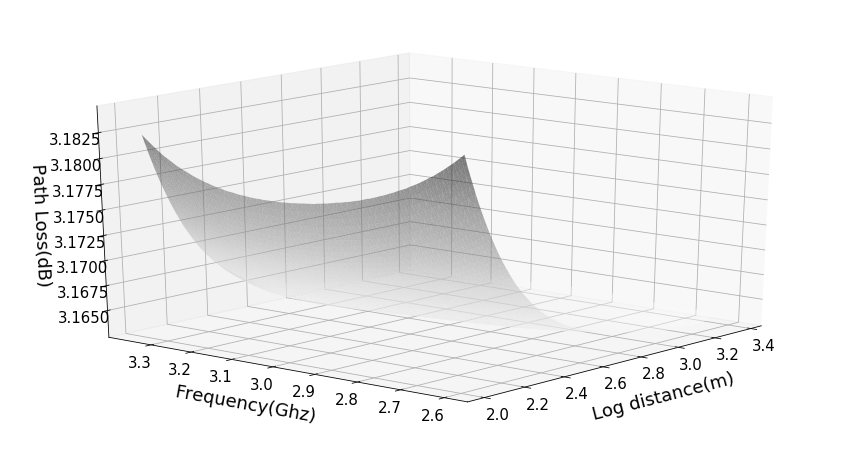

In [16]:
%autoreload
model = None
model = pickle.load(open('model/gp_DP_nonsan_wt_3d_model.sav', 'rb'))

print("<Nonsan - Winter> Gaussian Process STD(standard deviation) Distribution (dist<=2300m)")
mlp_train_multi_3dgraph_comb(model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'], True, 'Greys')

In [7]:
X = X_train_m
y = y_train_m

# Instantiate a Gaussian Process model
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
# kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
#    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)\
        + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel)
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

filename = 'model/gp_Matern_nonsan_wt_3d_model.sav'
pickle.dump(gp, open(filename, 'wb'))

<Nonsan - Winter> Gaussian Process (dist<=2300m)


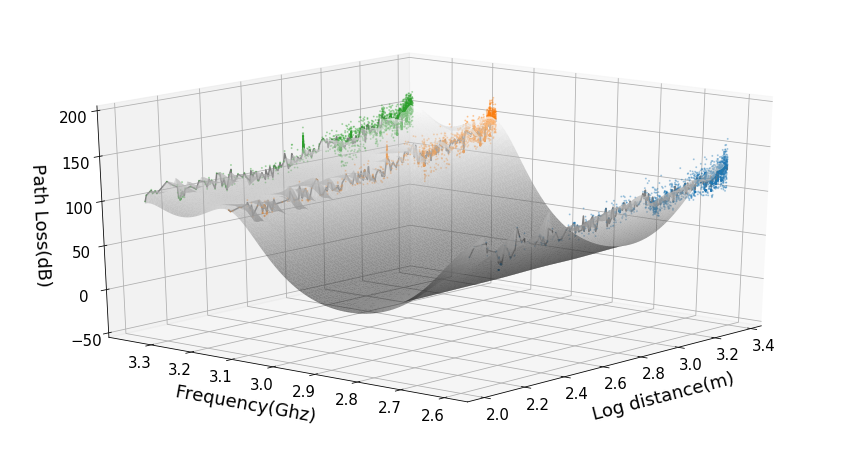

TEST ERROR(dB),RMSE,MAE,MAPE,MSLE,R2
0.4Ghz,7.45567,5.20871,4.55891,0.00418,0.58563
1.399Ghz,7.84885,5.84974,4.44802,0.00358,0.65411
2.249Ghz,7.52937,5.57458,4.21158,0.00324,0.64709
Overall,7.61314,5.54374,4.40684,0.00367,0.75060


In [12]:
%autoreload
model = None
model = pickle.load(open('model/gp_Matern_nonsan_wt_3d_model.sav', 'rb'))

print("<Nonsan - Winter> Gaussian Process (dist<=2300m)")
mlp_train_multi_3dgraph_comb(model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'], False, 'gray')

y_pred_400 = model.predict(X_val_m_400)
y_pred_1399 = model.predict(X_val_m_1399)
y_pred_2249 = model.predict(X_val_m_2249)
y_pred = model.predict(X_val_m)
stat = np.array([mlp_prediction_error(model,X_val_m_400, y_val_m_400),mean_absolute_error(y_pred_400, y_val_m_400),mean_absolute_percentage_error(y_pred_400, y_val_m_400),mean_squared_log_error(y_pred_400, y_val_m_400),r2_score(y_pred_400, y_val_m_400),
                 mlp_prediction_error(model,X_val_m_1399, y_val_m_1399),mean_absolute_error(y_pred_1399, y_val_m_1399),mean_absolute_percentage_error(y_pred_1399, y_val_m_1399),mean_squared_log_error(y_pred_1399, y_val_m_1399),r2_score(y_pred_1399, y_val_m_1399),
                 mlp_prediction_error(model,X_val_m_2249, y_val_m_2249),mean_absolute_error(y_pred_2249, y_val_m_2249),mean_absolute_percentage_error(y_pred_2249, y_val_m_2249),mean_squared_log_error(y_pred_2249, y_val_m_2249),r2_score(y_pred_2249, y_val_m_2249),
                 mlp_prediction_error(model,X_val_m, y_val_m), mean_absolute_error(y_pred, y_val_m),mean_absolute_percentage_error(y_pred, y_val_m),mean_squared_log_error(y_pred, y_val_m),r2_score(y_pred, y_val_m)])

(pd.DataFrame(stat.reshape((4,5)),index=pd.Index(['0.4Ghz','1.399Ghz','2.249Ghz', 'Overall']), columns=pd.Index(['RMSE','MAE','MAPE','MSLE','R2'],name='TEST ERROR(dB)')))

<Nonsan - Winter> Gaussian Process STD(standard deviation) Distribution (dist<=2300m)


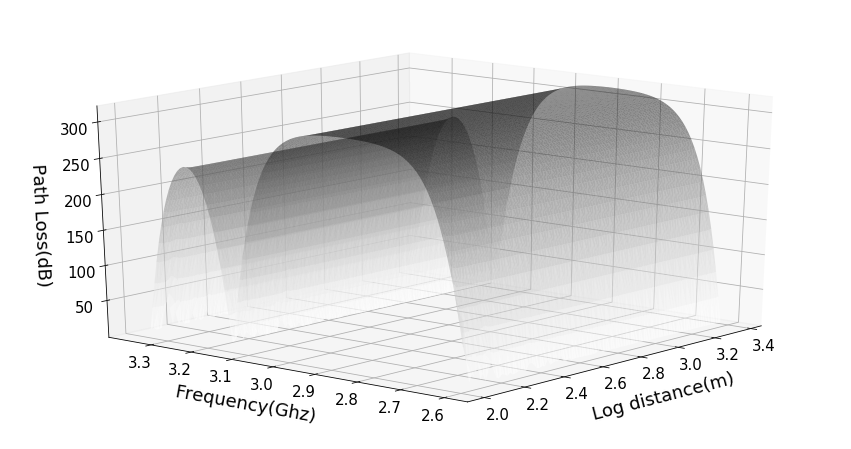

In [17]:
%autoreload
model = None
model = pickle.load(open('model/gp_Matern_nonsan_wt_3d_model.sav', 'rb'))

print("<Nonsan - Winter> Gaussian Process STD(standard deviation) Distribution (dist<=2300m)")
mlp_train_multi_3dgraph_comb(model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'], True, 'Greys')